# Supermarket Customer Analysis

### Objectives:
### Contents:

## 1. Import libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import davies_bouldin_score, silhouette_score

## 2. Loading data
Import data into df_orig as original dataset. Create copies of it for different data preprocessing steps.

In [2]:
df_orig = pd.read_csv('Supermarket_customers.csv', sep="\t")
df_orig.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

## 3. Descriptive Statistics
Start exploring the dataset by first creating a copy of the original into df.

In [3]:
df = df_orig.copy()
# Check the shape of the dataset
print(df.shape)

# Check the data types of each column
print(df.dtypes)

# Get a summary of the dataset
print(df.describe())

(2240, 29)
ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object
                 ID   Year_Birth         Income      Kidhome     Teenhome  \

### 3.1 Identifying/ Handling Missing Values

In [4]:
# Check for missing values in the 'Income' column
print(df['Income'].isnull().sum())

24


We have 24 missing values in the Income column. There are many ways to handle it, one is to fill it using the mode of Income with the same Education and Marital_Status columns. We could also add Age later and compare it with the existing results.

In [5]:
# Function to impute missing values in 'Income' with the mode based on 'Education' and 'Marital_Status'
def impute_mode(row):
    if pd.isnull(row['Income']):
        return df[(df['Education'] == row['Education']) & 
                  #(df['Age'] == row['Age']) &
                  (df['Marital_Status'] == row['Marital_Status'])]['Income'].mode()[0]
    else:
        return row['Income']

# Apply the function to fill missing values
df['Income'] = df.apply(impute_mode, axis=1)

### 3.2 Identifying/ Handling Outliers

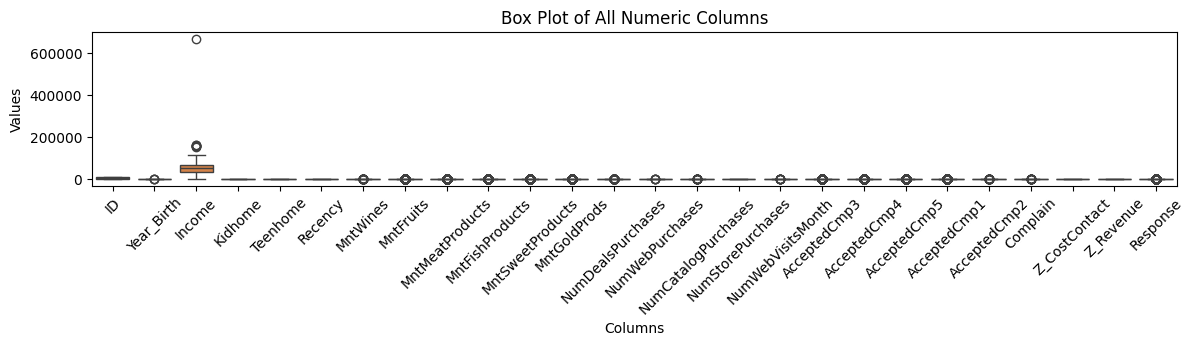

In [6]:
# Set the size of the plot
plt.figure(figsize=(14, 2))

# Create box plots for all numeric columns
sns.boxplot(data=df.select_dtypes(include=[np.number]))

# Add title and labels
plt.title('Box Plot of All Numeric Columns')
plt.xlabel('Columns')
plt.ylabel('Values')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [7]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Income'].quantile(0.25)
Q3 = df['Income'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier = 200000

# Remove outliers
#df = df[(df['Income'] >= lower_bound) & (df['Income'] <= upper_bound)]
df = df[(df['Income'] >= lower_bound) & (df['Income'] < outlier)]
df.shape

(2239, 29)

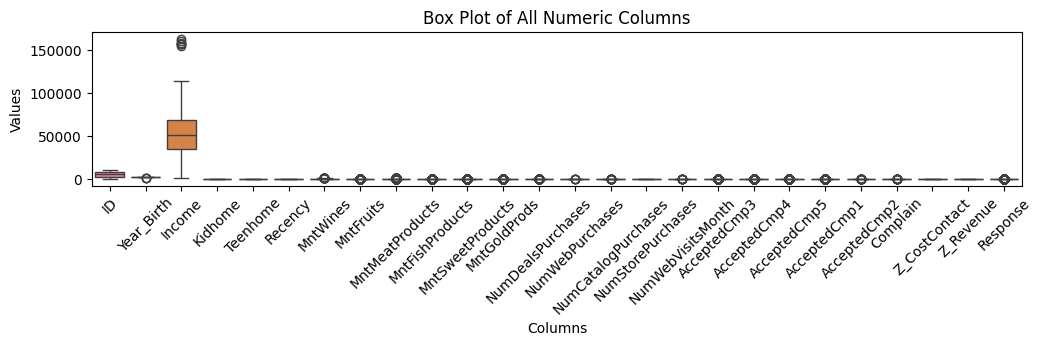

In [8]:
# Set the size of the plot
plt.figure(figsize=(12, 2))

# Create box plots for all numeric columns
sns.boxplot(data=df.select_dtypes(include=[np.number]))

# Add title and labels
plt.title('Box Plot of All Numeric Columns')
plt.xlabel('Columns')
plt.ylabel('Values')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [9]:
df.describe()

ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2239.000000  2239.000000    2239.000000  2239.000000  2239.000000   
mean    5590.444841  1968.802144   51621.071907     0.443948     0.506476   
std     3246.372471    11.985494   21744.205378     0.538390     0.544555   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2827.500000  1959.000000   34733.000000     0.000000     0.000000   
50%     5455.000000  1970.000000   51111.000000     0.000000     0.000000   
75%     8423.500000  1977.000000   68298.500000     1.000000     1.000000   
max    11191.000000  1996.000000  162397.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2239.000000  2239.000000  2239.000000      2239.000000   
mean     49.121036   304.067441    26.307727       167.016525   
std      28.963662   336.614830    39.781468       225.743829   
min       0.000000     0.000000     0.000000         0.000000   
25%      24.000000    24.000000     1.000000        16.000000   
50%      49.000000   174.000000     8.000000        67.000000   
75%      74.000000   504.500000    33.000000       232.000000   
max      99.000000  1493.000000   199.000000      1725.000000   

       MntFishProducts  ...  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
count      2239.000000  ...        2239.000000   2239.000000   2239.000000   
mean         37.538633  ...           5.316213      0.072800      0.074587   
std          54.637617  ...           2.427144      0.259867      0.262782   
min           0.000000  ...           0.000000      0.000000      0.000000   
25%           3.000000  ...           3.000000      0.000000      0.000000   
50%          12.000000  ...           6.000000      0.000000      0.000000   
75%          50.000000  ...           7.000000      0.000000      0.000000   
max         259.000000  ...          20.000000      1.000000      1.000000   

       AcceptedCmp5  AcceptedCmp1  AcceptedCmp2     Complain  Z_CostContact  \
count   2239.000000   2239.000000   2239.000000  2239.000000         2239.0   
mean       0.072800      0.064314      0.013399     0.009379            3.0   
std        0.259867      0.245367      0.115001     0.096412            0.0   
min        0.000000      0.000000      0.000000     0.000000            3.0   
25%        0.000000      0.000000      0.000000     0.000000            3.0   
50%        0.000000      0.000000      0.000000     0.000000            3.0   
75%        0.000000      0.000000      0.000000     0.000000            3.0   
max        1.000000      1.000000      1.000000     1.000000            3.0   

       Z_Revenue     Response  
count     2239.0  2239.000000  
mean        11.0     0.149174  
std          0.0     0.356339  
min         11.0     0.000000  
25%         11.0     0.000000  
50%         11.0     0.000000  
75%         11.0     0.000000  
max         11.0     1.000000  

[8 rows x 26 columns]

In [10]:
# Columns Z_CostContact and Z_Revenue have the same value for all entries and doesnt add anything to the data.
df.drop(columns=['Z_CostContact','Z_Revenue'], inplace=True, axis=1)

df = df.set_index('ID')

df.shape

(2239, 26)

In [11]:
avg_income_by_education = df.groupby('Education')['Income'].mean()
print('Education:', avg_income_by_education.round(2))

avg_income_by_maritalStatus = df.groupby('Marital_Status')['Income'].mean()
print('Marital Status:', avg_income_by_maritalStatus.round(2))

Education: Education
2n Cycle      47118.07
Basic         20306.26
Graduation    51801.17
Master        52477.10
PhD           55912.41
Name: Income, dtype: float64
Marital Status: Marital_Status
Absurd      72365.50
Alone       43789.00
Divorced    52834.23
Married     51429.40
Single      50323.19
Together    51870.98
Widow       56177.26
YOLO        48432.00
Name: Income, dtype: float64


### 3.3 Convert Data Types:

In [26]:
df['Age'] = 2024 - df['Year_Birth']
df.drop(['Year_Birth'], axis=1, inplace=True)

In [12]:
# Convert date strings to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='mixed')

In [27]:
# Create a new copy of dataset that has categorical features encoded
df_encoded = df.copy()

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=['Marital_Status'])

In [28]:
le = LabelEncoder()
df_encoded['Education'] = le.fit_transform(df['Education'])

In [29]:
# Changing the dateTime to integer
df_encoded['Dt_Customer'] = df_encoded['Dt_Customer'].dt.year.astype('int64')
df_encoded

Education   Income  Kidhome  Teenhome  Dt_Customer  Recency  MntWines  \
ID                                                                             
5524           2  58138.0        0         0         2012       58       635   
2174           2  46344.0        1         1         2014       38        11   
4141           2  71613.0        0         0         2013       26       426   
6182           2  26646.0        1         0         2014       26        11   
5324           4  58293.0        1         0         2014       94       173   
...          ...      ...      ...       ...          ...      ...       ...   
10870          2  61223.0        0         1         2013       46       709   
4001           4  64014.0        2         1         2014       56       406   
7270           2  56981.0        0         0         2014       91       908   
8235           3  69245.0        0         1         2014        8       428   
9405           4  52869.0        1         1         2012       40        84   

       MntFruits  MntMeatProducts  MntFishProducts  ...  Response  Age  \
ID                                                  ...                  
5524          88              546              172  ...         1   67   
2174           1                6                2  ...         0   70   
4141          49              127              111  ...         0   59   
6182           4               20               10  ...         0   40   
5324          43              118               46  ...         0   43   
...          ...              ...              ...  ...       ...  ...   
10870         43              182               42  ...         0   57   
4001           0               30                0  ...         0   78   
7270          48              217               32  ...         0   43   
8235          30              214               80  ...         0   68   
9405           3               61                2  ...         1   70   

       Marital_Status_Absurd  Marital_Status_Alone  Marital_Status_Divorced  \
ID                                                                            
5524                   False                 False                    False   
2174                   False                 False                    False   
4141                   False                 False                    False   
6182                   False                 False                    False   
5324                   False                 False                    False   
...                      ...                   ...                      ...   
10870                  False                 False                    False   
4001                   False                 False                    False   
7270                   False                 False                     True   
8235                   False                 False                    False   
9405                   False                 False                    False   

       Marital_Status_Married  Marital_Status_Single  Marital_Status_Together  \
ID                                                                              
5524                    False                   True                    False   
2174                    False                   True                    False   
4141                    False                  False                     True   
6182                    False                  False                     True   
5324                     True                  False                    False   
...                       ...                    ...                      ...   
10870                    True                  False                    False   
4001                    False                  False                     True   
7270                    False                  False                    False   
8235                    False                  False                     True   
940

## 4. Exploratory Data Analysis

- Uncover insights about customer behavior and campaign success.

### 4.1 Basic Distributions

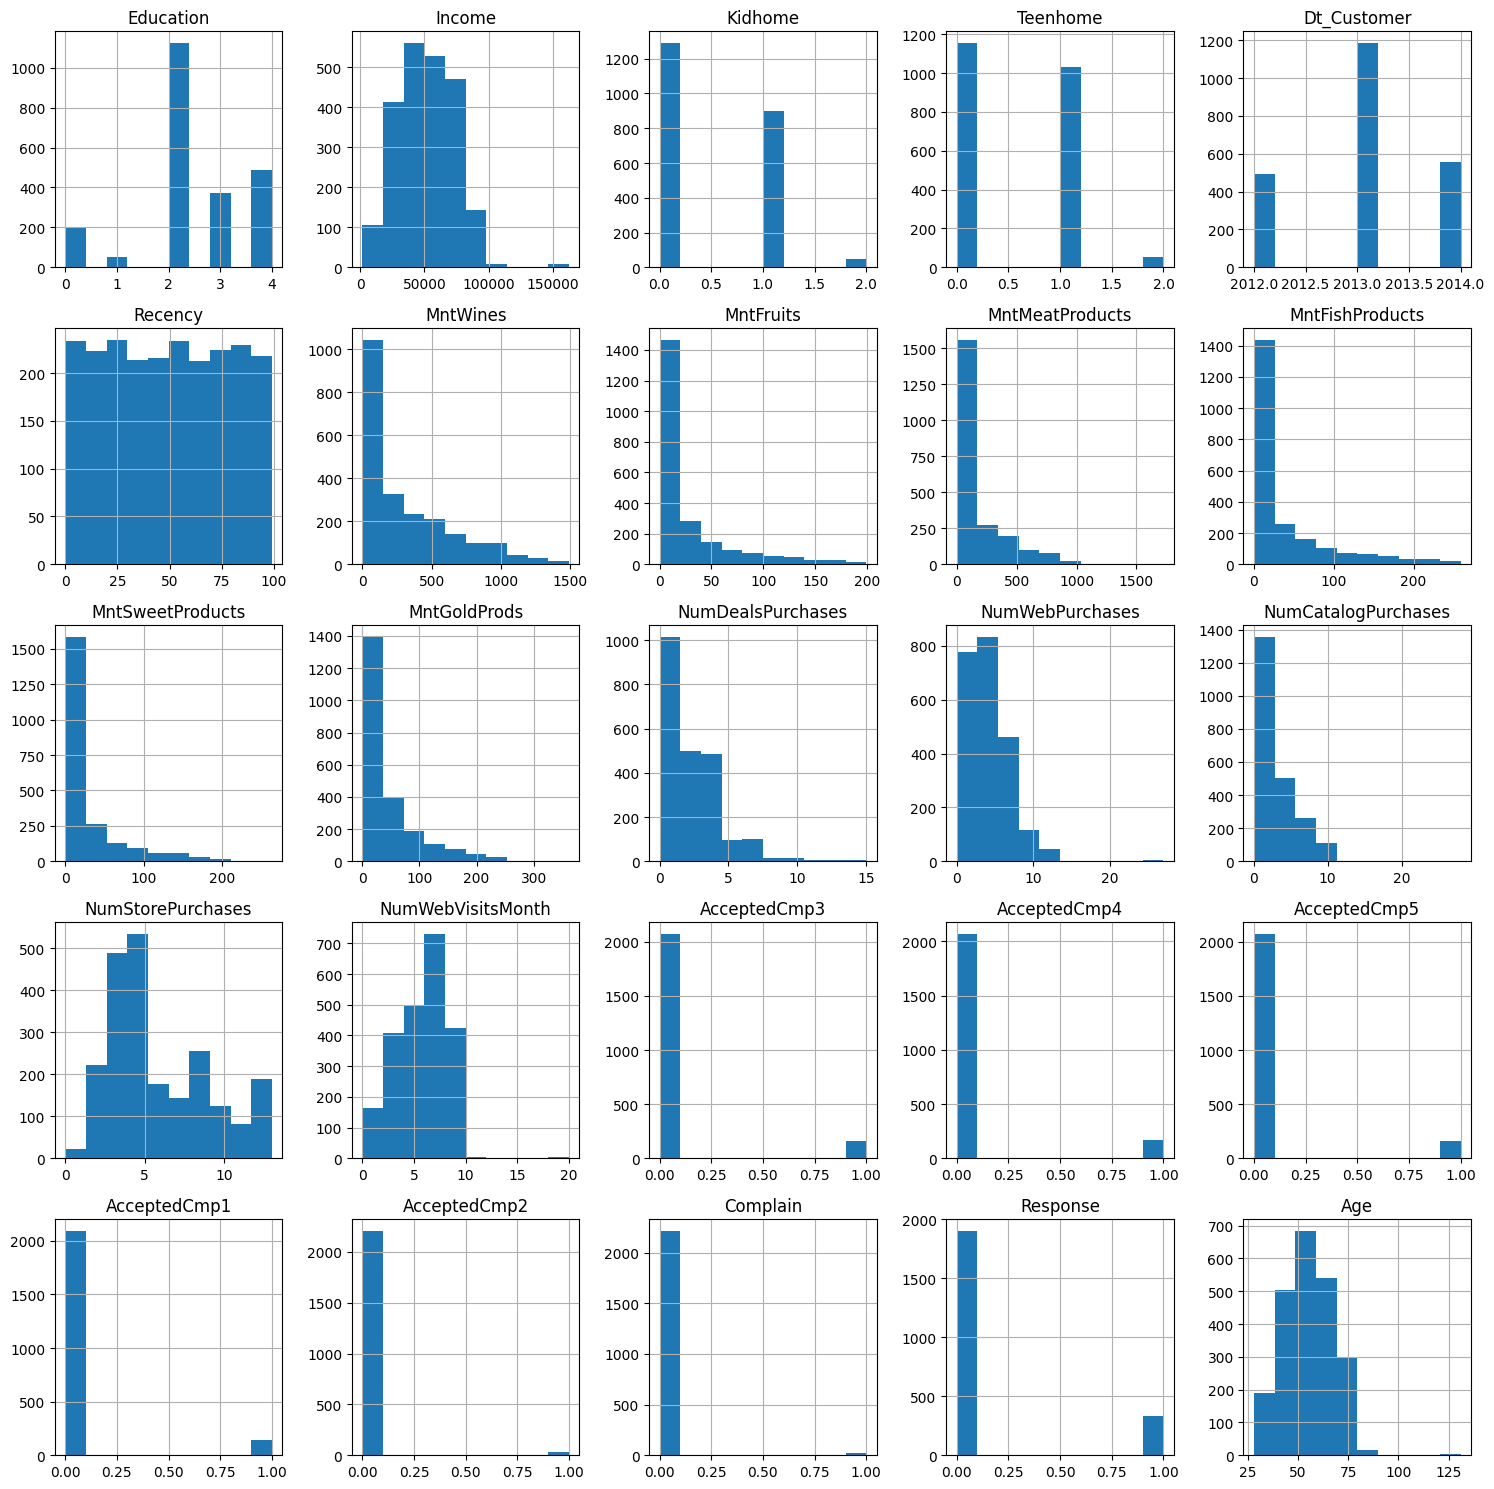

In [30]:
# Plot histograms for numerical variables.
axes = df_encoded.hist(figsize=(15, 15))

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

<Axes: xlabel='Education', ylabel='count'>

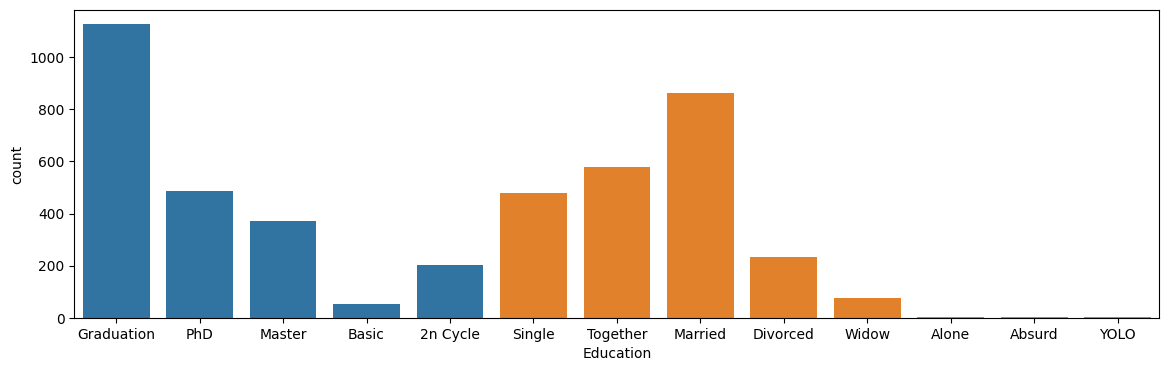

In [ ]:
# Visualize categorical distributions
plt.figure(figsize=(14, 4))

sns.countplot(data=df, x='Education')
sns.countplot(data=df, x='Marital_Status')

### Correlation between features

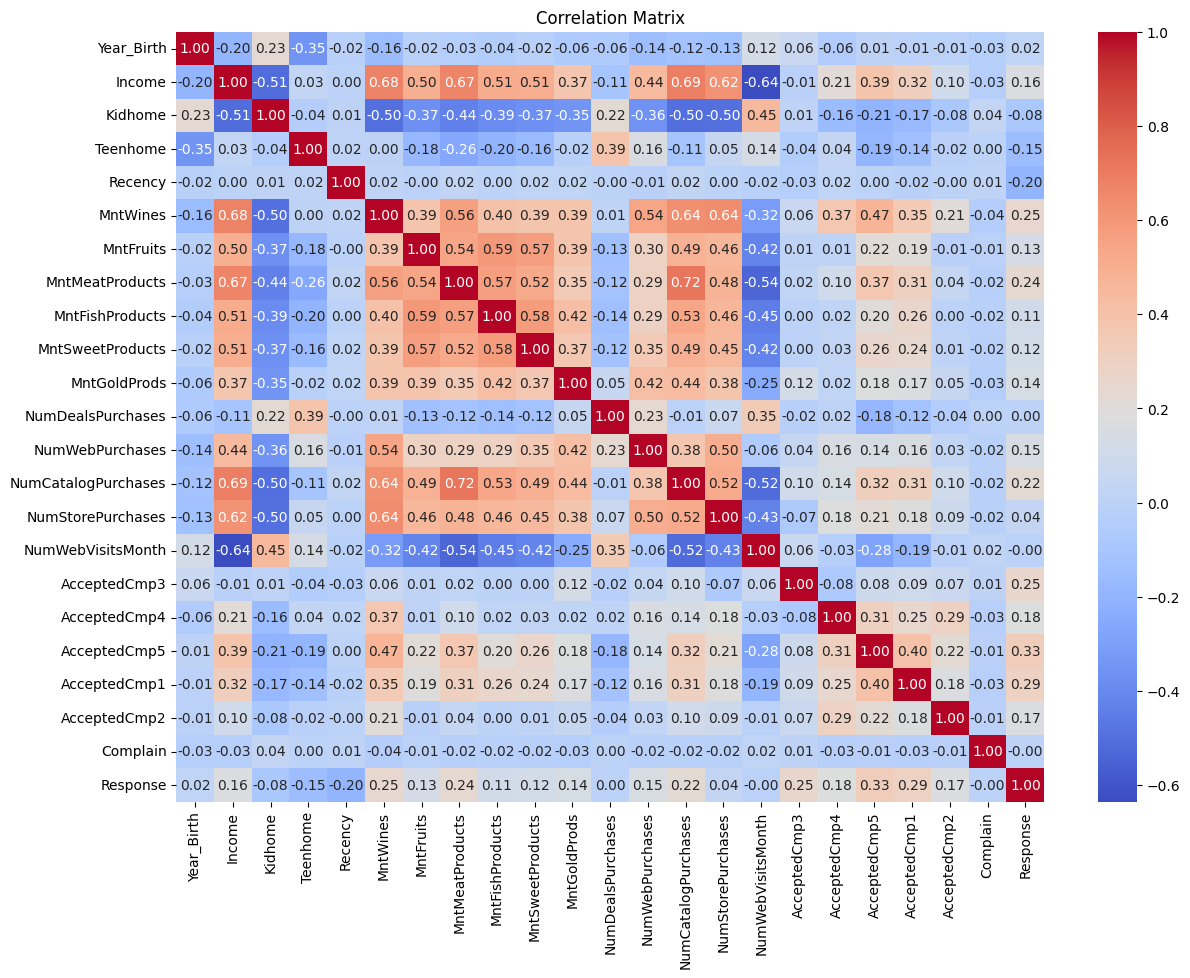

In [16]:
# Example heatmap for correlations of data before categorical encoding
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

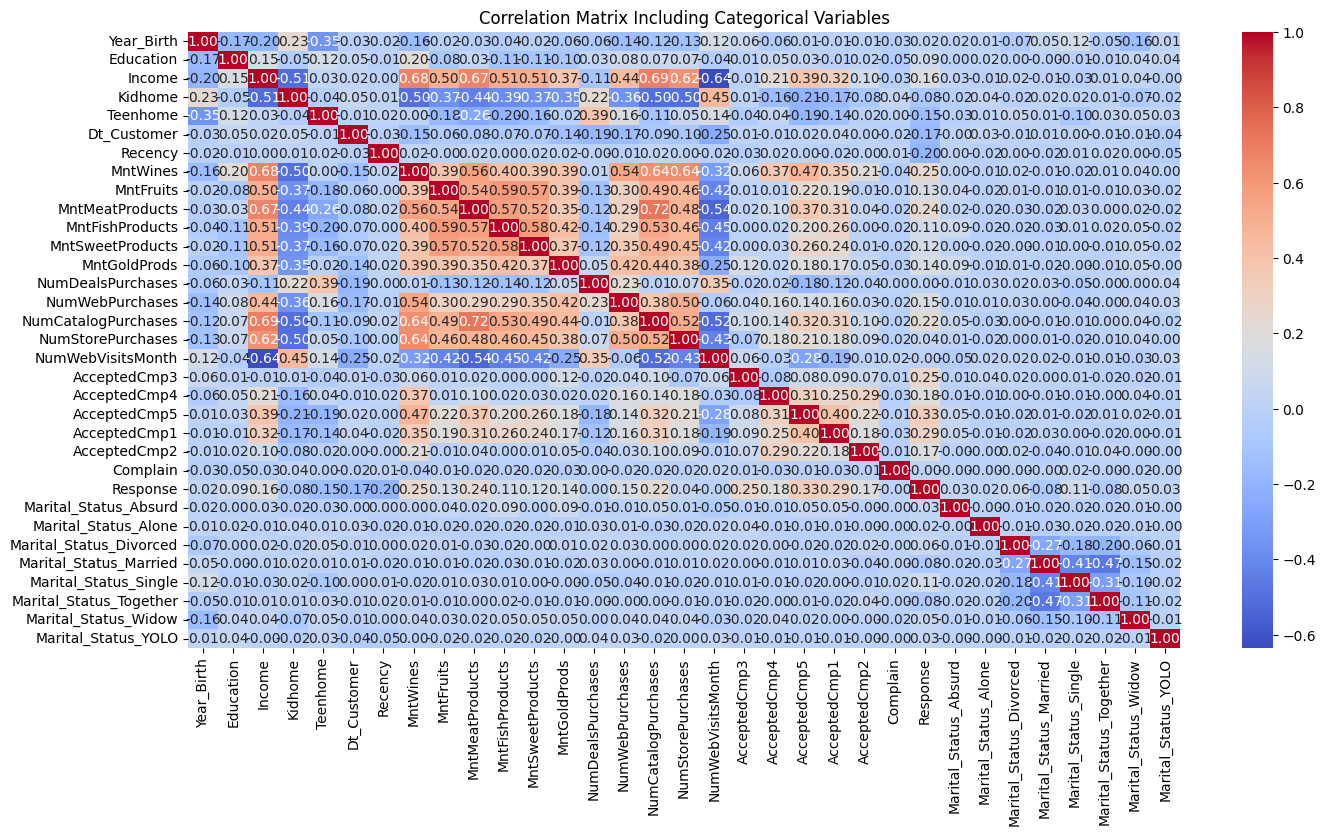

In [21]:
# Heatmap after categorical encoding
plt.figure(figsize=(16, 8))
sns.heatmap(df_encoded.corr(),annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Including Categorical Variables')
plt.show()

More detailed view of feature correlation with each other in a segmented view.

** Relation of Income with different products distinguished by resoponse **

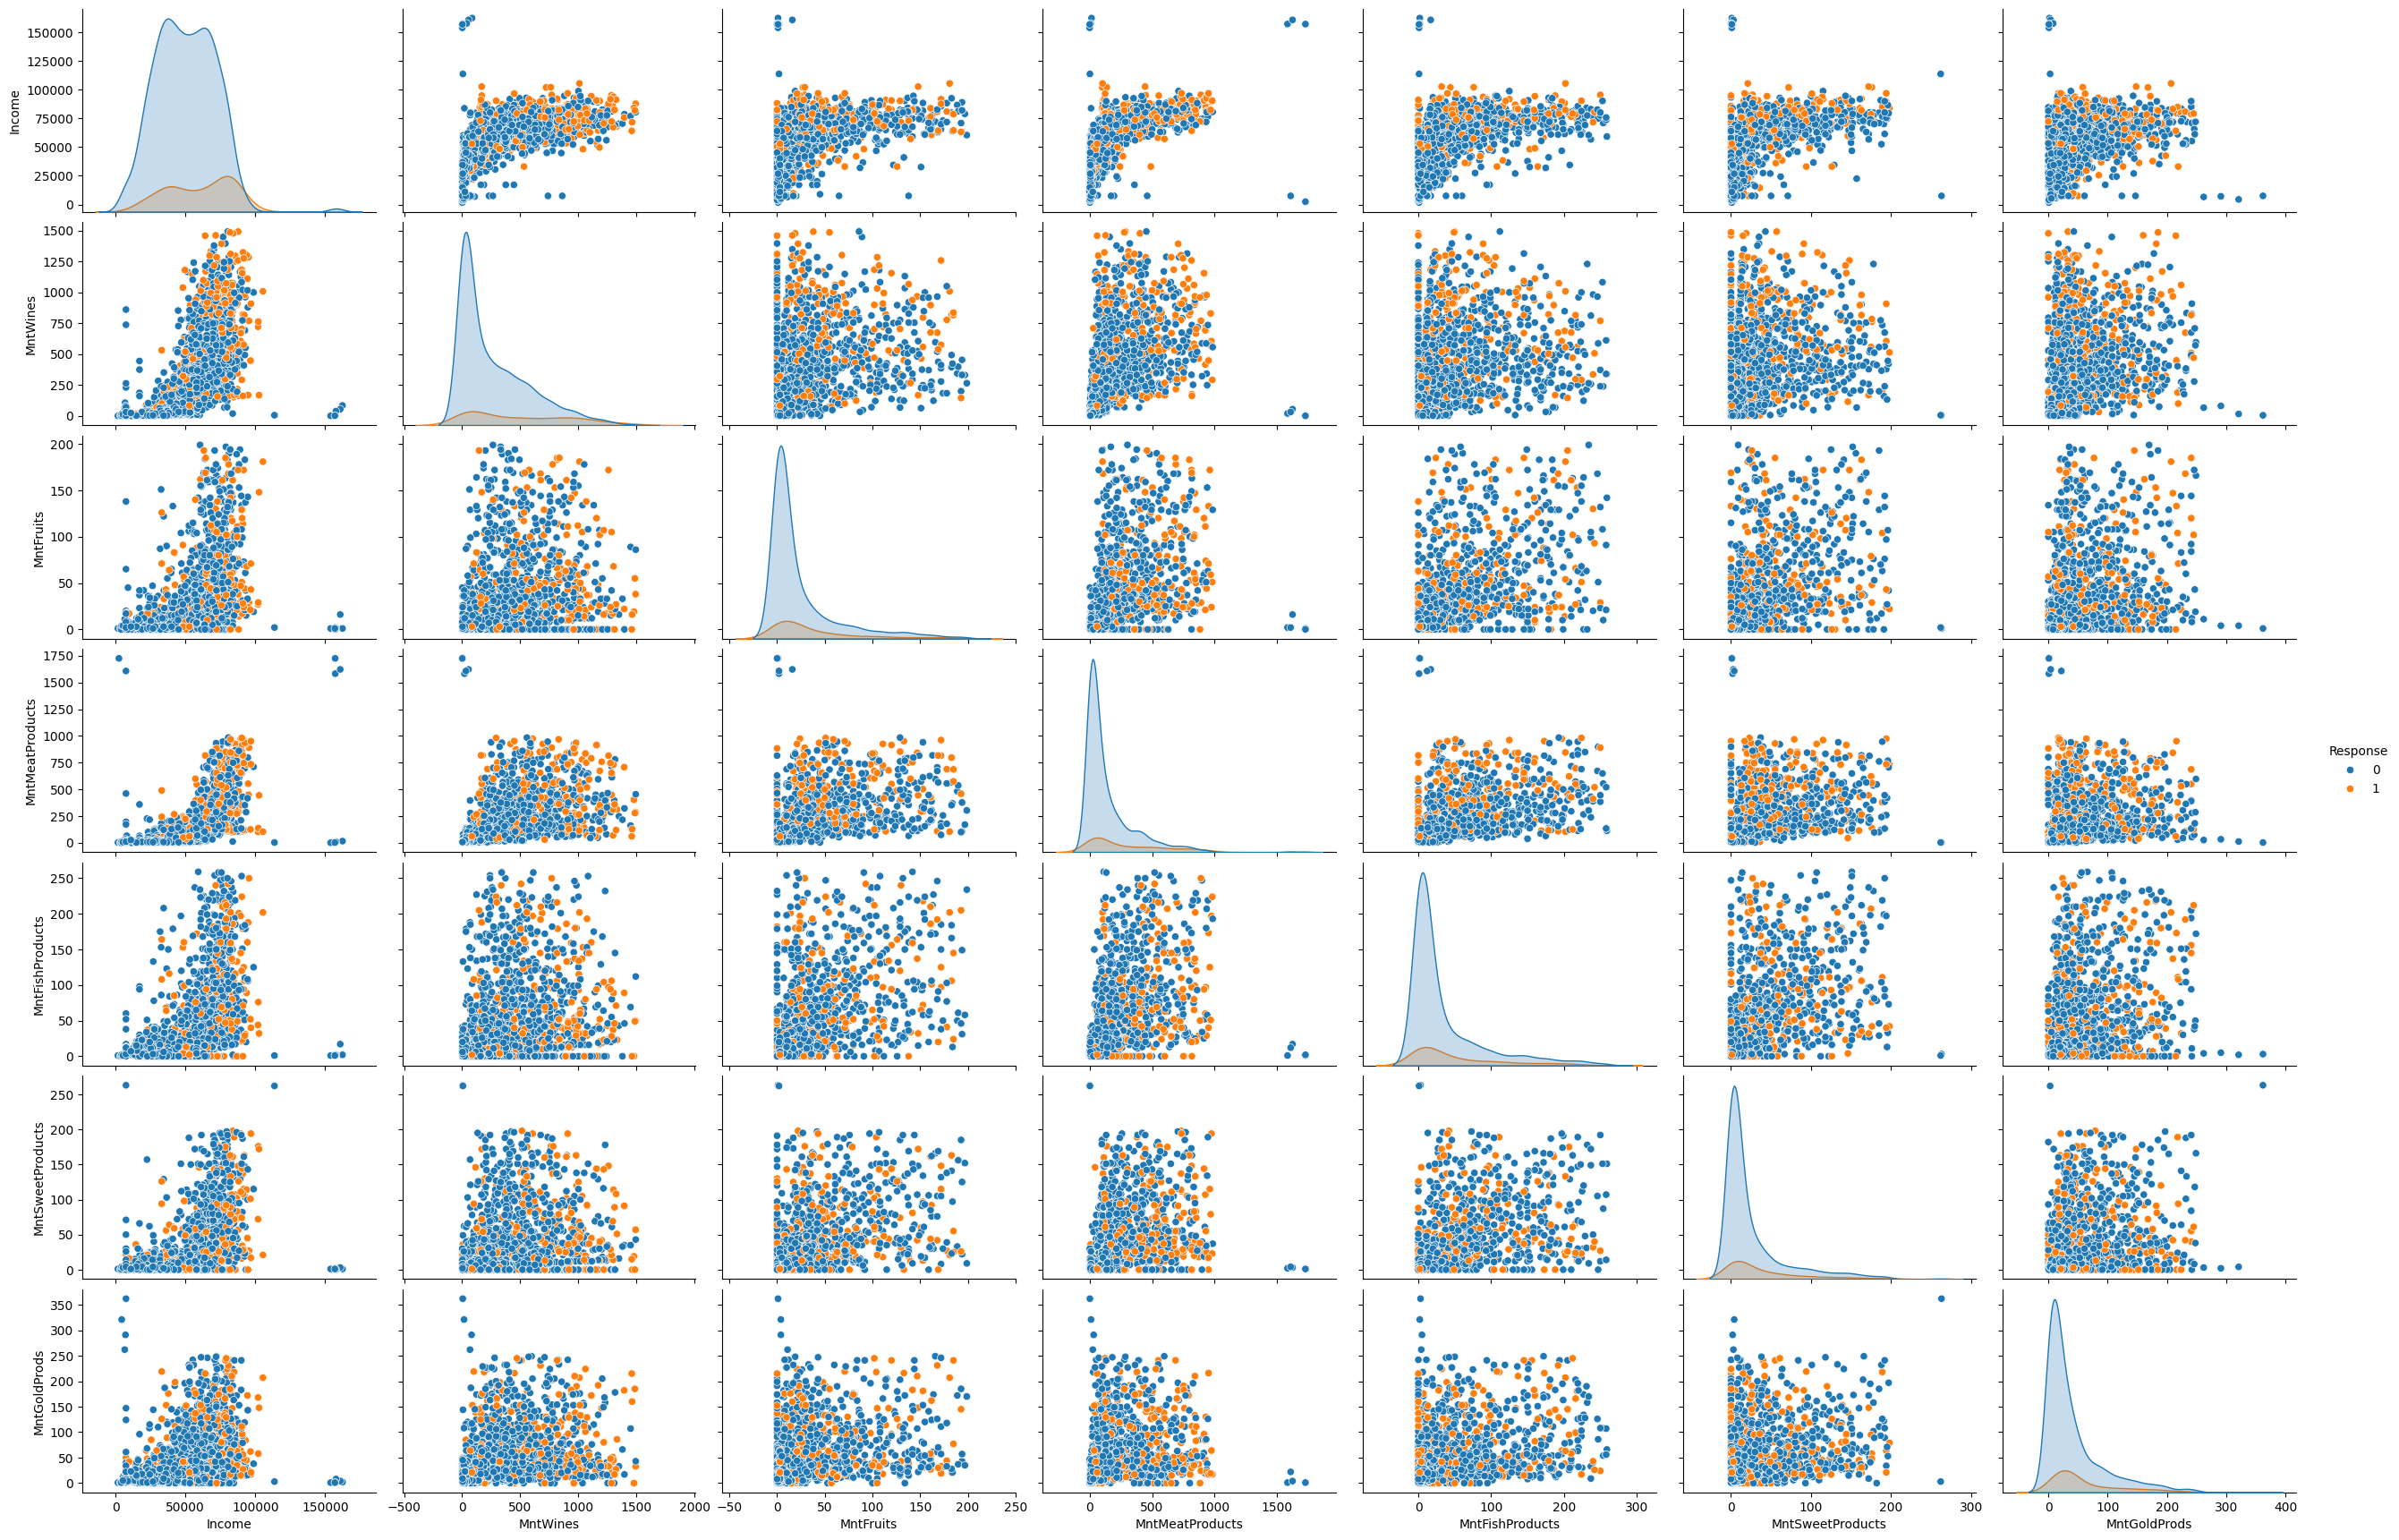

In [ ]:
Mnt_features = ['Income', 'MntWines', 'MntFruits','MntMeatProducts', 'MntFishProducts','MntSweetProducts', 'MntGoldProds', 'Response']
sns.pairplot(df[Mnt_features], hue='Response', height=2.5, aspect=1.5, diag_kind='kde')

In [ ]:
Mnt_features = ['Income', 'MntWines', 'MntFruits','MntMeatProducts', 'MntFishProducts','MntSweetProducts', 'MntGoldProds', 'Response']
sns.pairplot(df[Mnt_features], hue='Response', height=2.5, aspect=1.5, diag_kind='kde')

## 5. Scaling Data
Here we use two scaling methods since our data has some outliers, to see which one gives better results.

In [33]:
X = df_encoded

In [36]:
# Scale the data
rb_scaler = RobustScaler()
X_rb_scaled = rb_scaler.fit_transform(X)

In [37]:
st_scaler = StandardScaler()
X_st_scaled = st_scaler.fit_transform(X)

## 6. Dimensionality Reduction

** Factor Analysis **

In [41]:
fa = FactorAnalysis(n_components=2)
fa.fit(X_rb_scaled)
fa.noise_variance_

array([1.17094651e+00, 1.18787714e-01, 1.79951713e-01, 2.36612669e-01,
       4.47853316e-01, 3.35329737e-01, 1.10937579e-01, 8.04970905e-01,
       3.64051765e-01, 6.36457409e-01, 8.90534316e-01, 9.10811825e-01,
       7.56709064e-01, 2.80547202e-01, 1.83045442e-01, 1.95935090e-01,
       1.81429952e-01, 6.73307349e-02, 5.73338637e-02, 5.35060419e-02,
       5.11736505e-02, 1.25164527e-02, 9.27857295e-03, 1.18305615e-01,
       4.11788949e-01, 8.87814543e-04, 1.33639967e-03, 9.24617965e-02,
       2.36863461e-01, 1.66995662e-01, 1.91710349e-01, 3.30739683e-02,
       8.89982465e-04])

In [42]:
fa = FactorAnalysis(n_components=2)
fa.fit(X_st_scaled)
fa.noise_variance_

array([0.9287681 , 0.28204814, 0.6206298 , 0.79559788, 0.9491473 ,
       0.99985103, 0.23170638, 0.52548   , 0.33324876, 0.47659853,
       0.53919039, 0.73908506, 0.79911633, 0.57478853, 0.3425633 ,
       0.46048301, 0.48535151, 0.99787775, 0.83640747, 0.79419351,
       0.85091636, 0.94866771, 0.99862694, 0.93310139, 0.93190174,
       0.99549351, 0.99932195, 0.99593802, 0.99931623, 0.99172529,
       0.99997162, 0.99605541, 0.99723407])

** PCA **

In [ ]:
pca = PCA(n_components=2)
pca_comps = pca.fit_transform(X_rb_scaled)
pca_comps.shape

(2239, 2)

In [ ]:
pca_df = pd.DataFrame(pca_comps, columns=['P1','P2'])
pca_df

** t-SNE **

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(X_rb_scaled)

In [ ]:
tsne_df = pd.DataFrame(tsne, columns=['T1','T2'])
tsne_df

## 7. Clustering
Here we use multiple clustering methods to compare the results and findout the best one for this data.

### Heirarchical/ Agglomerative Clustering

### K-Means Clustering

### DBSCAN Clustering